## 1. Import Required Libraries

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import os
import pandas as pd
from datetime import datetime

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
Keras version: 3.12.0
GPU Available: []


## 2. Set Parameters and Paths

In [26]:
# Paths
BASE_DIR = os.path.dirname(os.path.abspath('.'))
TRAIN_DIR = os.path.join(BASE_DIR, 'data', 'train')
TEST_DIR = os.path.join(BASE_DIR, 'data', 'test')
MODEL_DIR = os.path.join(BASE_DIR, 'models')

# Create directories if they don't exist
os.makedirs(MODEL_DIR, exist_ok=True)

# Hyperparameters (Quick Mode - optimized for fast training)
IMG_SIZE = (128, 128)  # Reduced for faster training (was 224x224)
BATCH_SIZE = 64  # Increased for faster training
EPOCHS = 50
LEARNING_RATE = 0.0001
NUM_CLASSES = None  # Will be automatically detected from your dataset

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 3. Data Loading and Preprocessing

We'll use ImageDataGenerator for:
- Data augmentation (rotation, flipping, zooming)
- Normalization
- Batch generation

In [27]:
# Training data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2  # 80% training, 20% validation
)

# Test data preprocessing (no augmentation)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

print("Data generators created successfully!")

Data generators created successfully!


In [28]:
# Load training data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Automatically detect number of classes
NUM_CLASSES = len(train_generator.class_indices)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"\nNumber of classes detected: {NUM_CLASSES}")
print(f"Class indices: {train_generator.class_indices}")

Found 47332 images belonging to 36 classes.
Found 11820 images belonging to 36 classes.
Found 11820 images belonging to 36 classes.
Found 12705 images belonging to 36 classes.
Found 12705 images belonging to 36 classes.

Training samples: 47332
Validation samples: 11820
Test samples: 12705

Number of classes detected: 36
Class indices: {'Bell_pepper__Bell_pepper_Bacterial_spot': 0, 'Bell_pepper__Bell_pepper_Healthy': 1, 'Brinjal__Diseased_Brinjal_Leaf_-_Cercospora_Leaf_Spot': 2, 'Brinjal__Fresh_Brinjal_Leaf': 3, 'Cabbage__Alternaria_Leaf_Spot': 4, 'Cabbage__Bacterial_spot_rot': 5, 'Cabbage__Black_Rot': 6, 'Cabbage__Cabbage_aphid_colony': 7, 'Cabbage__Downy_Mildew': 8, 'Cabbage__Healthy': 9, 'Cabbage__club_root': 10, 'Cabbage__ring_spot': 11, 'Citrus__Citrus_Black_spot': 12, 'Citrus__Citrus_Healthy': 13, 'Citrus__Citrus_canker': 14, 'Citrus__Citrus_greening': 15, 'Corn__Corn_Common_rust': 16, 'Corn__Corn_Gray_leaf_spot': 17, 'Corn__Corn_Healthy': 18, 'Corn__Corn_Northern_Leaf_Blight': 1

## 4. Visualize Sample Images

Sample training images with augmentation:


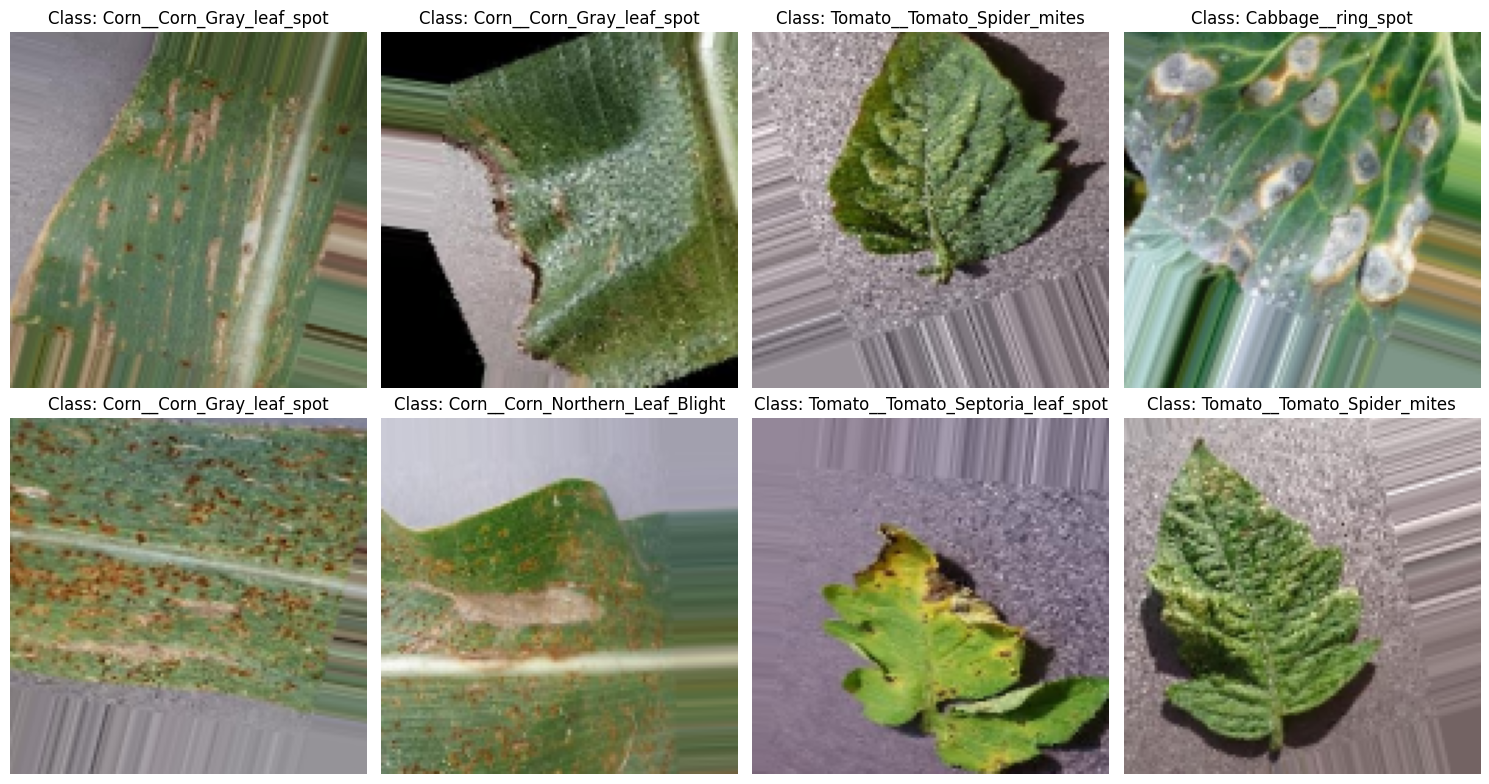

In [29]:
# Visualize augmented images
def plot_images(generator, num_images=8):
    images, labels = next(generator)
    class_names = list(generator.class_indices.keys())
    
    plt.figure(figsize=(15, 8))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        label_idx = np.argmax(labels[i])
        plt.title(f"Class: {class_names[label_idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Sample training images with augmentation:")
plot_images(train_generator)

## 5. Model Creation using Transfer Learning

We'll use **MobileNetV2** as our pretrained model:
- Lightweight and efficient for deployment
- Pre-trained on ImageNet
- Fine-tuning approach for better performance

In [30]:
def create_model(num_classes=2, learning_rate=0.0001):
    """
    Create a model using MobileNetV2 as the base (pretrained model)
    with custom top layers for our classification task.
    
    Optimization techniques used:
    - Transfer Learning with pretrained MobileNetV2
    - Batch Normalization
    - Dropout for regularization (0.5)
    - Adam optimizer with custom learning rate
    - L2 regularization on dense layers
    """
    # Load pretrained MobileNetV2 without top layers
    base_model = MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model layers initially
    base_model.trainable = False
    
    # Create custom top layers
    inputs = keras.Input(shape=(*IMG_SIZE, 3))
    
    # Preprocessing
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    
    # Base model
    x = base_model(x, training=False)
    
    # Custom top layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', 
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall')]
    )
    
    return model, base_model

# Create the model
model, base_model = create_model(num_classes=NUM_CLASSES, learning_rate=LEARNING_RATE)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,628,580 (10.03 MB)

 Trainable params: 368,036 (1.40 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

## 6. Setup Callbacks for Optimization

Callbacks used:
- **EarlyStopping**: Stop training when validation loss stops improving
- **ModelCheckpoint**: Save best model based on validation accuracy
- **ReduceLROnPlateau**: Reduce learning rate when validation loss plateaus

In [31]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        os.path.join(MODEL_DIR, 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured successfully!")

Callbacks configured successfully!


## 7. Train the Model - Phase 1 (Frozen Base)

In [32]:
print("=" * 60)
print("PHASE 1: Training with frozen base model (Quick Mode)")
print("=" * 60)

history_phase1 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,  # Reduced for quick training
    callbacks=callbacks,
    verbose=1
)

print("\nPhase 1 training completed!")

PHASE 1: Training with frozen base model (Quick Mode)
Epoch 1/5
Epoch 1/5
740/740 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1374 - loss: 7.3794 - precision: 0.4245 - recall: 0.0072
Epoch 1: val_accuracy improved from None to 0.33503, saving model to c:\MLOps_Image_Classification\models\best_model.h5

Epoch 1: val_accuracy improved from None to 0.33503, saving model to c:\MLOps_Image_Classification\models\best_model.h5


740/740 ━━━━━━━━━━━━━━━━━━━━ 1303s 2s/step - accuracy: 0.1976 - loss: 5.9835 - precision: 0.6219 - recall: 0.0198 - val_accuracy: 0.3350 - val_loss: 4.1976 - val_precision: 0.8981 - val_recall: 0.0313 - learning_rate: 1.0000e-04
Epoch 2/5
Epoch 2/5
740/740 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2829 - loss: 4.0070 - precision: 0.6822 - recall: 0.0574
Epoch 2: val_accuracy improved from 0.33503 to 0.38782, saving model to c:\MLOps_Image_Classification\models\best_model.h5

Epoch 2: val_accuracy improved from 0.33503 to 0.38782, saving model to c:\MLOps_Image_Classification\models\best_model.h5


740/740 ━━━━━━━━━━━━━━━━━━━━ 1490s 2s/step - accuracy: 0.2944 - loss: 3.7779 - precision: 0.6853 - recall: 0.0643 - val_accuracy: 0.3878 - val_loss: 3.2077 - val_precision: 0.8650 - val_recall: 0.0856 - learning_rate: 1.0000e-04
Epoch 3/5
Epoch 3/5
740/740 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3329 - loss: 3.2257 - precision: 0.7242 - recall: 0.0880
Epoch 3: val_accuracy improved from 0.38782 to 0.41404, saving model to c:\MLOps_Image_Classification\models\best_model.h5

Epoch 3: val_accuracy improved from 0.38782 to 0.41404, saving model to c:\MLOps_Image_Classification\models\best_model.h5


740/740 ━━━━━━━━━━━━━━━━━━━━ 2294s 3s/step - accuracy: 0.3365 - loss: 3.1222 - precision: 0.7262 - recall: 0.0916 - val_accuracy: 0.4140 - val_loss: 2.7537 - val_precision: 0.8618 - val_recall: 0.1229 - learning_rate: 1.0000e-04
Epoch 4/5
Epoch 4/5
740/740 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3574 - loss: 2.8443 - precision: 0.7350 - recall: 0.1066
Epoch 4: val_accuracy improved from 0.41404 to 0.42174, saving model to c:\MLOps_Image_Classification\models\best_model.h5

Epoch 4: val_accuracy improved from 0.41404 to 0.42174, saving model to c:\MLOps_Image_Classification\models\best_model.h5


740/740 ━━━━━━━━━━━━━━━━━━━━ 1516s 2s/step - accuracy: 0.3593 - loss: 2.7831 - precision: 0.7378 - recall: 0.1100 - val_accuracy: 0.4217 - val_loss: 2.5137 - val_precision: 0.8362 - val_recall: 0.1387 - learning_rate: 1.0000e-04
Epoch 5/5
Epoch 5/5
740/740 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3694 - loss: 2.6180 - precision: 0.7467 - recall: 0.1189
Epoch 5: val_accuracy improved from 0.42174 to 0.43249, saving model to c:\MLOps_Image_Classification\models\best_model.h5

Epoch 5: val_accuracy improved from 0.42174 to 0.43249, saving model to c:\MLOps_Image_Classification\models\best_model.h5


740/740 ━━━━━━━━━━━━━━━━━━━━ 1608s 2s/step - accuracy: 0.3714 - loss: 2.5784 - precision: 0.7414 - recall: 0.1215 - val_accuracy: 0.4325 - val_loss: 2.3512 - val_precision: 0.8510 - val_recall: 0.1469 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.
Restoring model weights from the end of the best epoch: 5.

Phase 1 training completed!

Phase 1 training completed!


## 8. Fine-tune the Model - Phase 2 (Unfrozen Base)

In [33]:
print("=" * 60)
print("PHASE 2: Fine-tuning with unfrozen base model (Quick Mode)")
print("=" * 60)

# Unfreeze the base model
base_model.trainable = True

# Freeze early layers, only fine-tune later layers
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE / 10),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

print(f"\nTrainable layers: {sum([1 for layer in model.layers if layer.trainable])}")
print(f"Total layers: {len(model.layers)}")

# Continue training
history_phase2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Reduced for quick training
    callbacks=callbacks,
    verbose=1
)

print("\nPhase 2 fine-tuning completed!")

PHASE 2: Fine-tuning with unfrozen base model (Quick Mode)

Trainable layers: 9
Total layers: 9

Trainable layers: 9
Total layers: 9
Epoch 1/10
Epoch 1/10
740/740 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2657 - loss: 2.9403 - precision: 0.5599 - recall: 0.0833
Epoch 1: val_accuracy did not improve from 0.43249
740/740 ━━━━━━━━━━━━━━━━━━━━ 1423s 2s/step - accuracy: 0.3253 - loss: 2.6785 - precision: 0.6541 - recall: 0.1232 - val_accuracy: 0.0475 - val_loss: 6.0819 - val_precision: 0.0475 - val_recall: 0.0475 - learning_rate: 1.0000e-05
Epoch 2/10

Epoch 1: val_accuracy did not improve from 0.43249
740/740 ━━━━━━━━━━━━━━━━━━━━ 1423s 2s/step - accuracy: 0.3253 - loss: 2.6785 - precision: 0.6541 - recall: 0.1232 - val_accuracy: 0.0475 - val_loss: 6.0819 - val_precision: 0.0475 - val_recall: 0.0475 - learning_rate: 1.0000e-05
Epoch 2/10
740/740 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3962 - loss: 2.3928 - precision: 0.7179 - recall: 0.1864
Epoch 2: val_accuracy did not improve fr

## 9. Training History Visualization

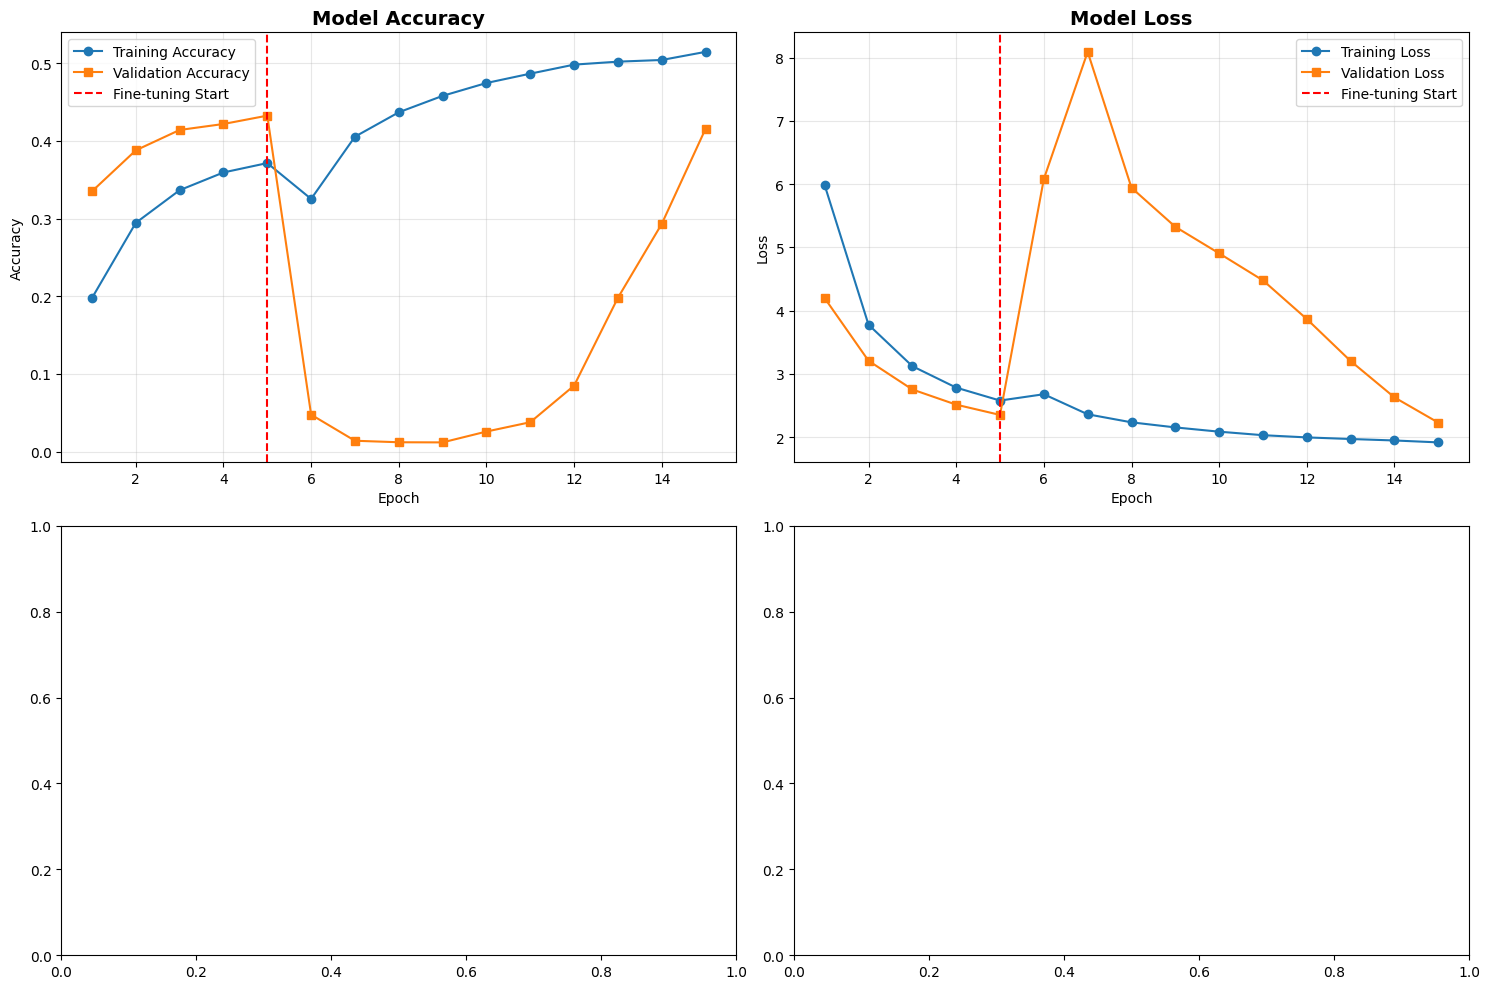

In [34]:
def plot_training_history(history1, history2=None):
    """
    Plot training and validation metrics over epochs
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Combine histories if phase 2 exists
    if history2:
        history = {
            'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
            'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
            'loss': history1.history['loss'] + history2.history['loss'],
            'val_loss': history1.history['val_loss'] + history2.history['val_loss']
        }
        phase1_epochs = len(history1.history['accuracy'])
    else:
        history = history1.history
        phase1_epochs = 0
    
    epochs_range = range(1, len(history['accuracy']) + 1)
    
    # Accuracy
    axes[0, 0].plot(epochs_range, history['accuracy'], label='Training Accuracy', marker='o')
    axes[0, 0].plot(epochs_range, history['val_accuracy'], label='Validation Accuracy', marker='s')
    if phase1_epochs:
        axes[0, 0].axvline(x=phase1_epochs, color='r', linestyle='--', label='Fine-tuning Start')
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(epochs_range, history['loss'], label='Training Loss', marker='o')
    axes[0, 1].plot(epochs_range, history['val_loss'], label='Validation Loss', marker='s')
    if phase1_epochs:
        axes[0, 1].axvline(x=phase1_epochs, color='r', linestyle='--', label='Fine-tuning Start')
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision (if available)
    if 'precision' in history:
        axes[1, 0].plot(epochs_range, history['precision'], label='Training Precision', marker='o')
        axes[1, 0].plot(epochs_range, history['val_precision'], label='Validation Precision', marker='s')
        if phase1_epochs:
            axes[1, 0].axvline(x=phase1_epochs, color='r', linestyle='--', label='Fine-tuning Start')
        axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Recall (if available)
    if 'recall' in history:
        axes[1, 1].plot(epochs_range, history['recall'], label='Training Recall', marker='o')
        axes[1, 1].plot(epochs_range, history['val_recall'], label='Validation Recall', marker='s')
        if phase1_epochs:
            axes[1, 1].axvline(x=phase1_epochs, color='r', linestyle='--', label='Fine-tuning Start')
        axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_phase1, history_phase2)

## 10. Model Evaluation on Test Data

Comprehensive evaluation using multiple metrics:
1. **Accuracy**: Overall correctness
2. **Loss**: Model's error rate
3. **Precision**: True positives / (True positives + False positives)
4. **Recall**: True positives / (True positives + False negatives)
5. **F1-Score**: Harmonic mean of Precision and Recall
6. **Confusion Matrix**: Visual representation of predictions

In [35]:
print("=" * 60)
print("MODEL EVALUATION ON TEST DATA")
print("=" * 60)

# Evaluate on test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator, verbose=1)

print(f"\n{'='*60}")
print("EVALUATION METRICS")
print(f"{'='*60}")
print(f"Test Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"Test Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")

# Calculate F1 Score
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"Test F1-Score:  {test_f1:.4f} ({test_f1*100:.2f}%)")
print(f"{'='*60}\n")

MODEL EVALUATION ON TEST DATA
199/199 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.5069 - loss: 1.8991 - precision: 0.8033 - recall: 0.3080
199/199 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.5069 - loss: 1.8991 - precision: 0.8033 - recall: 0.3080

EVALUATION METRICS
Test Accuracy:  0.5069 (50.69%)
Test Loss:      1.8991
Test Precision: 0.8033 (80.33%)
Test Recall:    0.3080 (30.80%)
Test F1-Score:  0.4453 (44.53%)


EVALUATION METRICS
Test Accuracy:  0.5069 (50.69%)
Test Loss:      1.8991
Test Precision: 0.8033 (80.33%)
Test Recall:    0.3080 (30.80%)
Test F1-Score:  0.4453 (44.53%)



## 11. Detailed Classification Report and Confusion Matrix

In [36]:
# Get predictions
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Classification report
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Calculate per-class metrics
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

print("\nPer-Class Metrics Summary:")
for i, class_name in enumerate(class_names):
    print(f"\n{class_name}:")
    print(f"  Precision: {precision_per_class[i]:.4f}")
    print(f"  Recall:    {recall_per_class[i]:.4f}")
    print(f"  F1-Score:  {f1_per_class[i]:.4f}")

199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 266ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 55s 266ms/step

DETAILED CLASSIFICATION REPORT

DETAILED CLASSIFICATION REPORT
                                                       precision    recall  f1-score   support

              Bell_pepper__Bell_pepper_Bacterial_spot     0.3327    0.6332    0.4362       518
                     Bell_pepper__Bell_pepper_Healthy     0.4179    0.6202    0.4993       603
Brinjal__Diseased_Brinjal_Leaf_-_Cercospora_Leaf_Spot     0.3372    0.3694    0.3526       157
                          Brinjal__Fresh_Brinjal_Leaf     0.4219    0.7135    0.5303       178
                        Cabbage__Alternaria_Leaf_Spot     0.0000    0.0000    0.0000        30
                          Cabbage__Bacterial_spot_rot     0.0000    0.0000    0.0000        30
                                   Cabbage__Black_Rot     0.0000    0.0000    0.0000        30
                        Cabbage__Cabbage_aphid_colony     0.0000    0.0000    0.0000   

c:\MLOps_Image_Classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\MLOps_Image_Classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\MLOps_Image_Classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

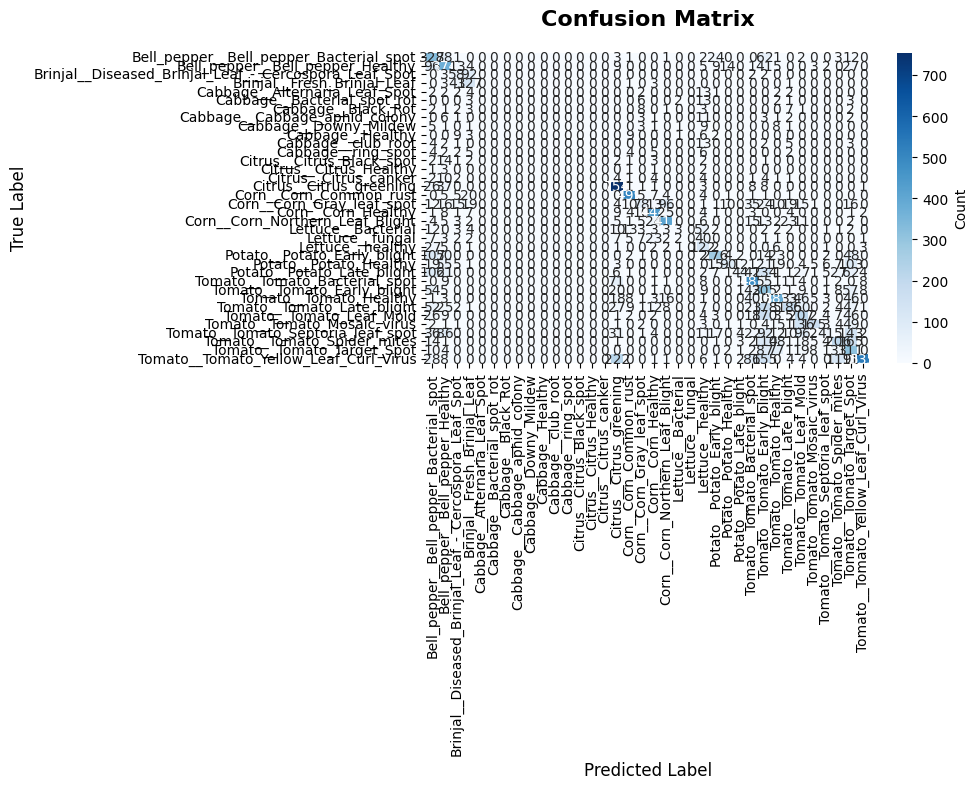

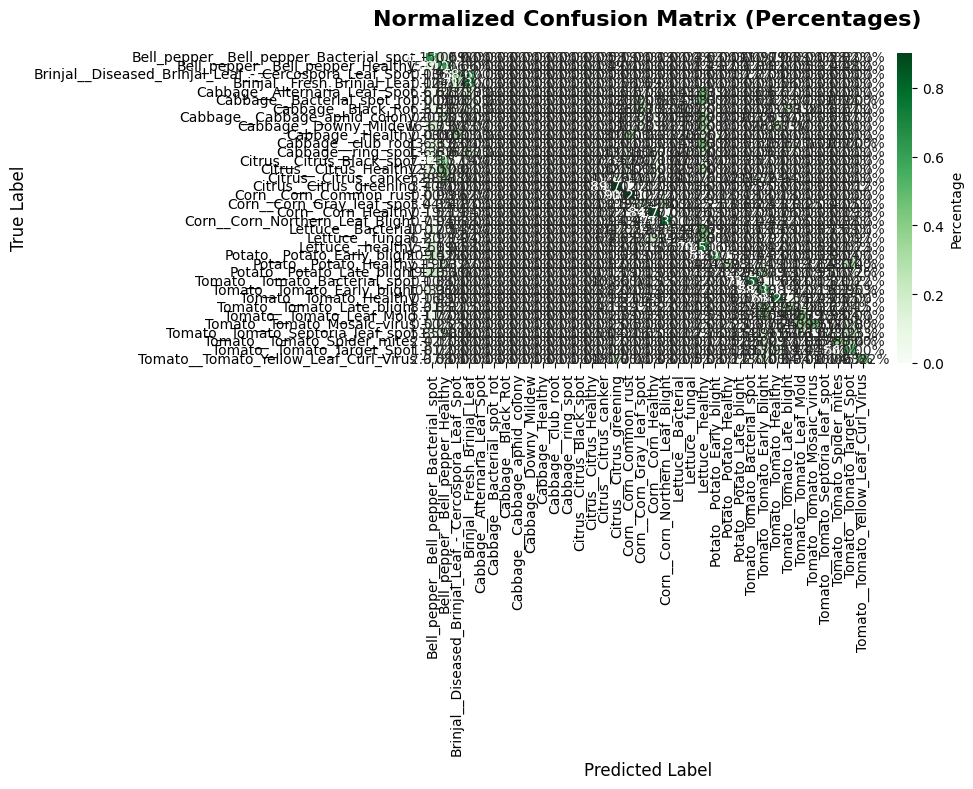

In [37]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix (Percentages)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

## 12. Visualize Predictions

Sample predictions from test set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


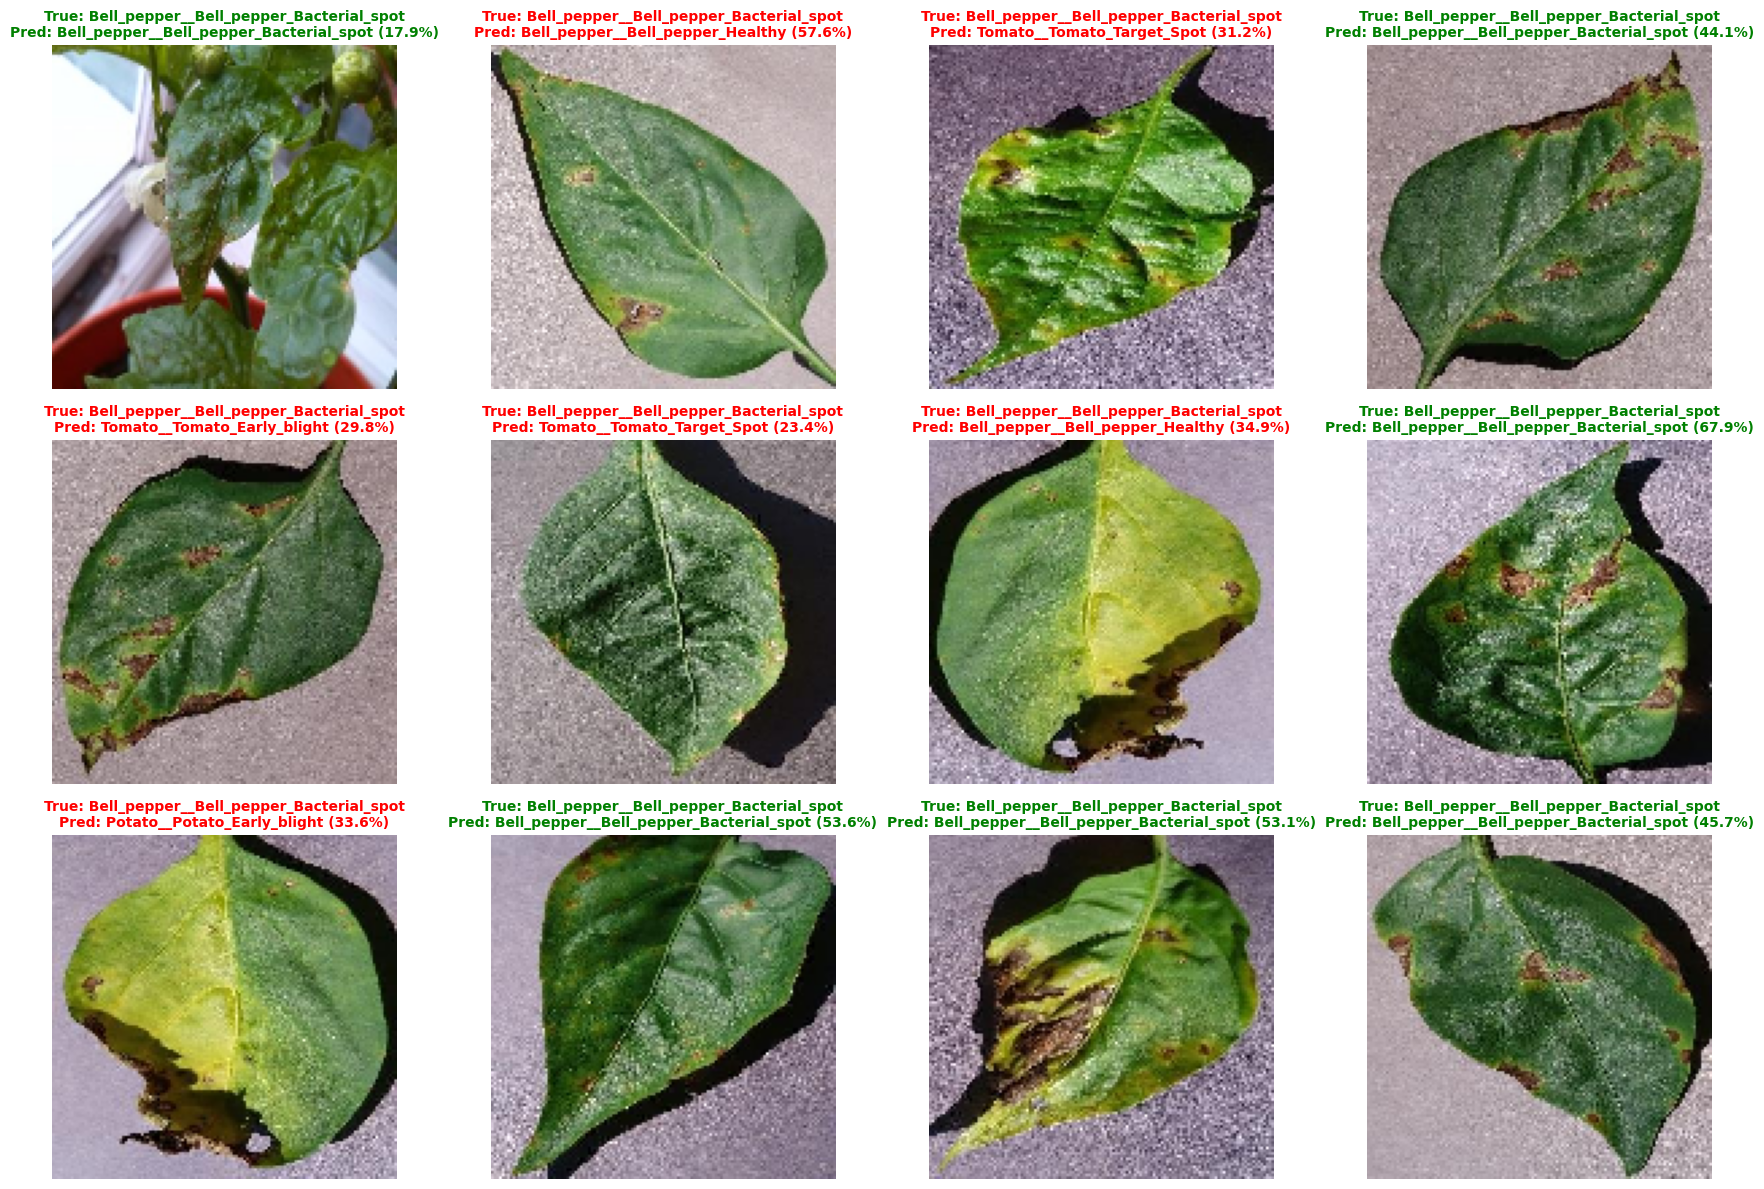

In [38]:
# Visualize some predictions
def visualize_predictions(generator, model, num_images=12):
    generator.reset()
    images, true_labels = next(generator)
    predictions = model.predict(images[:num_images])
    
    class_names = list(generator.class_indices.keys())
    
    plt.figure(figsize=(18, 12))
    for i in range(min(num_images, len(images))):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        
        true_idx = np.argmax(true_labels[i])
        pred_idx = np.argmax(predictions[i])
        confidence = predictions[i][pred_idx] * 100
        
        true_label = class_names[true_idx]
        pred_label = class_names[pred_idx]
        
        color = 'green' if true_idx == pred_idx else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)", 
                 color=color, fontsize=10, fontweight='bold')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Sample predictions from test set:")
visualize_predictions(test_generator, model)

## 13. Save the Model

In [41]:
# Save the final model in native Keras format
model_path = os.path.join(MODEL_DIR, 'image_classifier_model.keras')
model.save(model_path)
print(f"Model saved to: {model_path}")

# Also save in .h5 format for backward compatibility with Flask app
h5_model_path = os.path.join(MODEL_DIR, 'image_classifier_model.h5')
model.save(h5_model_path)
print(f"Model also saved to: {h5_model_path}")

# Save class indices
import json
class_indices_path = os.path.join(MODEL_DIR, 'class_indices.json')
with open(class_indices_path, 'w') as f:
    json.dump(train_generator.class_indices, f)
print(f"Class indices saved to: {class_indices_path}")

Model saved to: c:\MLOps_Image_Classification\models\image_classifier_model.keras
Model also saved to: c:\MLOps_Image_Classification\models\image_classifier_model.h5
Class indices saved to: c:\MLOps_Image_Classification\models\class_indices.json
Model also saved to: c:\MLOps_Image_Classification\models\image_classifier_model.h5
Class indices saved to: c:\MLOps_Image_Classification\models\class_indices.json


## 14. Model Summary and Final Metrics

### Summary of Evaluation Metrics:

| Metric | Value | Description |
|--------|-------|-------------|
| **Accuracy** | Test Accuracy | Overall percentage of correct predictions |
| **Loss** | Test Loss | Cross-entropy loss on test set |
| **Precision** | Test Precision | Ratio of true positives to predicted positives |
| **Recall** | Test Recall | Ratio of true positives to actual positives |
| **F1-Score** | Test F1 | Harmonic mean of precision and recall |

### Optimization Techniques Used:

1. **Transfer Learning**: MobileNetV2 pretrained on ImageNet
2. **Data Augmentation**: Rotation, flipping, zooming, shifting
3. **Regularization**: 
   - Dropout (0.5 and 0.3)
   - L2 regularization (0.01)
4. **Batch Normalization**: For stable training
5. **Early Stopping**: Prevent overfitting
6. **Learning Rate Reduction**: Adaptive learning rate
7. **Fine-tuning**: Two-phase training approach
8. **Adam Optimizer**: Adaptive learning rate optimization

### Model Architecture:
- Base: MobileNetV2 (pretrained)
- Global Average Pooling
- Dense Layer 1: 256 units (ReLU + L2 + Dropout 0.5)
- Dense Layer 2: 128 units (ReLU + L2 + Dropout 0.3)
- Output Layer: 2 units (Softmax)

In [42]:
# Create a summary report
report = {
    'model_name': 'MobileNetV2 Transfer Learning',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_metrics': {
        'accuracy': float(test_accuracy),
        'loss': float(test_loss),
        'precision': float(test_precision),
        'recall': float(test_recall),
        'f1_score': float(test_f1)
    },
    'training_samples': train_generator.samples,
    'validation_samples': validation_generator.samples,
    'test_samples': test_generator.samples,
    'classes': class_names,
    'hyperparameters': {
        'img_size': IMG_SIZE,
        'batch_size': BATCH_SIZE,
        'initial_learning_rate': LEARNING_RATE,
        'epochs_phase1': len(history_phase1.history['accuracy']),
        'epochs_phase2': len(history_phase2.history['accuracy'])
    }
}

# Save report
report_path = os.path.join(MODEL_DIR, 'model_report.json')
with open(report_path, 'w') as f:
    json.dump(report, f, indent=4)

print("\n" + "="*60)
print("MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"\nModel report saved to: {report_path}")
print(f"\nFinal Test Metrics:")
print(f"  - Accuracy:  {test_accuracy:.4f}")
print(f"  - Loss:      {test_loss:.4f}")
print(f"  - Precision: {test_precision:.4f}")
print(f"  - Recall:    {test_recall:.4f}")
print(f"  - F1-Score:  {test_f1:.4f}")
print("\nThe model is ready for deployment!")


MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!

Model report saved to: c:\MLOps_Image_Classification\models\model_report.json

Final Test Metrics:
  - Accuracy:  0.5069
  - Loss:      1.8991
  - Precision: 0.8033
  - Recall:    0.3080
  - F1-Score:  0.4453

The model is ready for deployment!
